In [1]:
from matplotlib.colors import LogNorm

import jax.numpy as jnp

import matplotlib.pyplot as plt


In [3]:
losses = jnp.empty((4,11_000_000), dtype=jnp.float32)
for i, L in enumerate([3, 5, 7, 9]):
    losses = losses.at[i,:].set(jnp.concat(
        [
            jnp.load(f"data/loss_CNN-G-{L}.npy"),
            jnp.load(f"data/loss_CNN-P-{L}.npy"),
            jnp.load(f"data/loss_CNN-P-{L}-Specialized.npy"),
        ]
    ))
losses

Array([[5.0343537e-01, 5.2657676e-01, 5.1854610e-01, ..., 9.1421790e-04,
        5.1871186e-05, 6.6056123e-06],
       [7.1285254e-01, 6.4756441e-01, 5.1729620e-01, ..., 3.8205699e-06,
        4.8613828e-08, 6.8589588e-06],
       [8.9736128e-01, 8.8580054e-01, 7.5421590e-01, ..., 1.2525721e-06,
        1.7756933e-05, 1.1117388e-06],
       [1.0191190e+00, 8.8191199e-01, 9.7963655e-01, ..., 2.8165127e-03,
        2.5622249e-02, 5.9404641e-07]], dtype=float32)

/tmp/ipykernel_1457878/1618433940.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


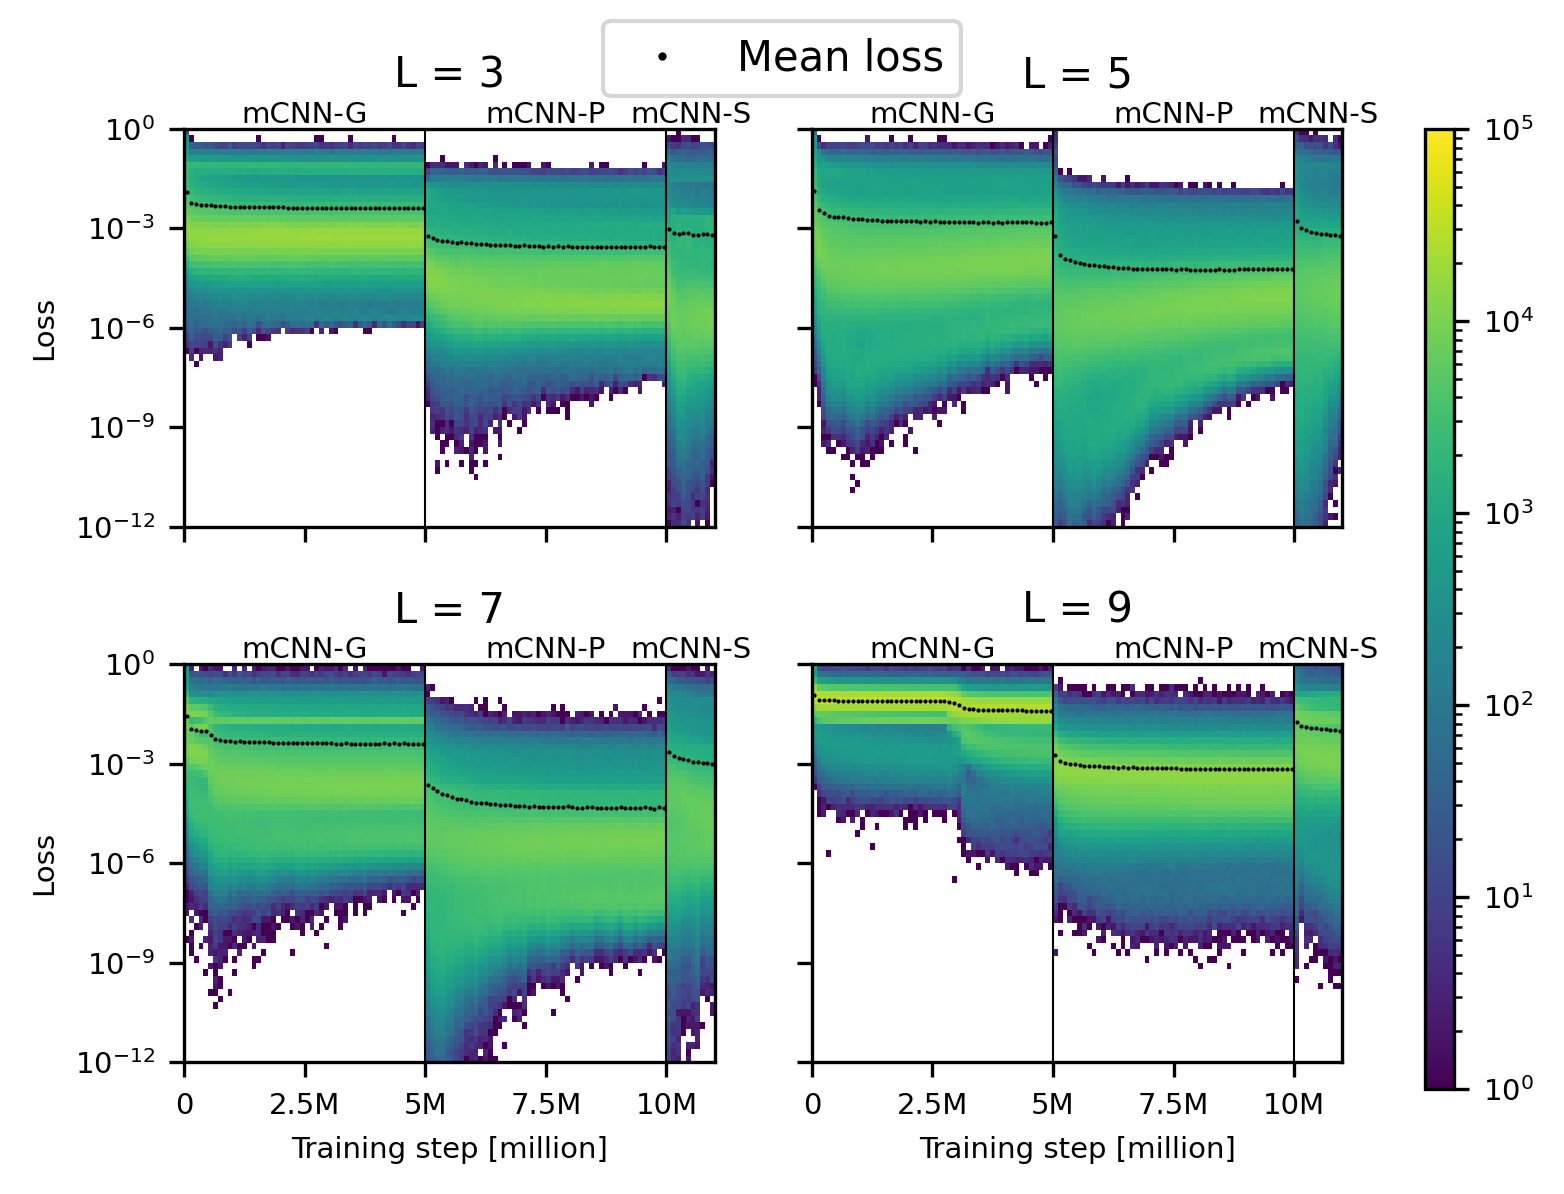

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(4.8, 4), sharex=True, sharey=True, dpi=300)

x_res = 110
y_res = 60

for i, ax in enumerate(axes.flat):
    loss = losses[i]
    ax.hist2d(
        x=jnp.arange(loss.shape[0]), 
        y=loss, 
        bins=[
            jnp.linspace(0, loss.shape[0], x_res+1),
            jnp.logspace(-12, 0, y_res+1),
        ],
        norm=LogNorm(vmin=1, vmax=1E5),
    )
    ax.plot(
        jnp.arange(x_res) * loss.shape[0] / x_res + loss.shape[0] / x_res / 2, 
        loss.reshape(-1, loss.shape[0] // x_res).mean(axis=1),
        '.k', 
        lw=0.5, 
        ms=2,
        mew=0,
        label='Mean loss'
    )
    ax.axvline(x=5e6, color='k', linestyle='-', lw=.5)
    ax.axvline(x=10e6, color='k', linestyle='-', lw=.5)
    ax.text(2.5e6,  1E-0, 'mCNN-G', ha='center', va='bottom', fontsize=7, color='k')
    ax.text(7.5e6,  1E-0, 'mCNN-P', ha='center', va='bottom', fontsize=7, color='k')
    ax.text(10.5e6, 1E-0, 'mCNN-S', ha='center', va='bottom', fontsize=7, color='k')
    ax.set_yscale('log')
    ax.set_yticks([1E-12, 1E-9, 1E-6, 1E-3, 1E0])
    ax.set_xticks([0, 2.5e6, 5e6, 7.5e6, 10e6])
    ax.set_xticklabels(['0', '2.5M', '5M', '7.5M', '10M'])
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.set_title(f'L = {2*i+3}', fontsize=10, pad=10)
    if i % 2 == 0:
        ax.set_ylabel('Loss', fontsize=7)
    if i >= 2:
        ax.set_xlabel('Training step [million]', fontsize=7)
        
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', markerscale=2)

cbar_ax = fig.add_axes([1, 0.1, 0.02, 0.8])  # Add a new axis for the colorbar
cbar = fig.colorbar(ax.collections[0], cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=7)
# cbar.set_label('Loss density', fontsize=8)

plt.tight_layout()

plt.savefig('figs/losses-probdist-method.eps', bbox_inches='tight', dpi=300)
plt.savefig('figs/losses-probdist-method.pdf', bbox_inches='tight', dpi=300)
plt.savefig('figs/losses-probdist-method.png', bbox_inches='tight', dpi=300)

plt.show()

decoder_loss-7


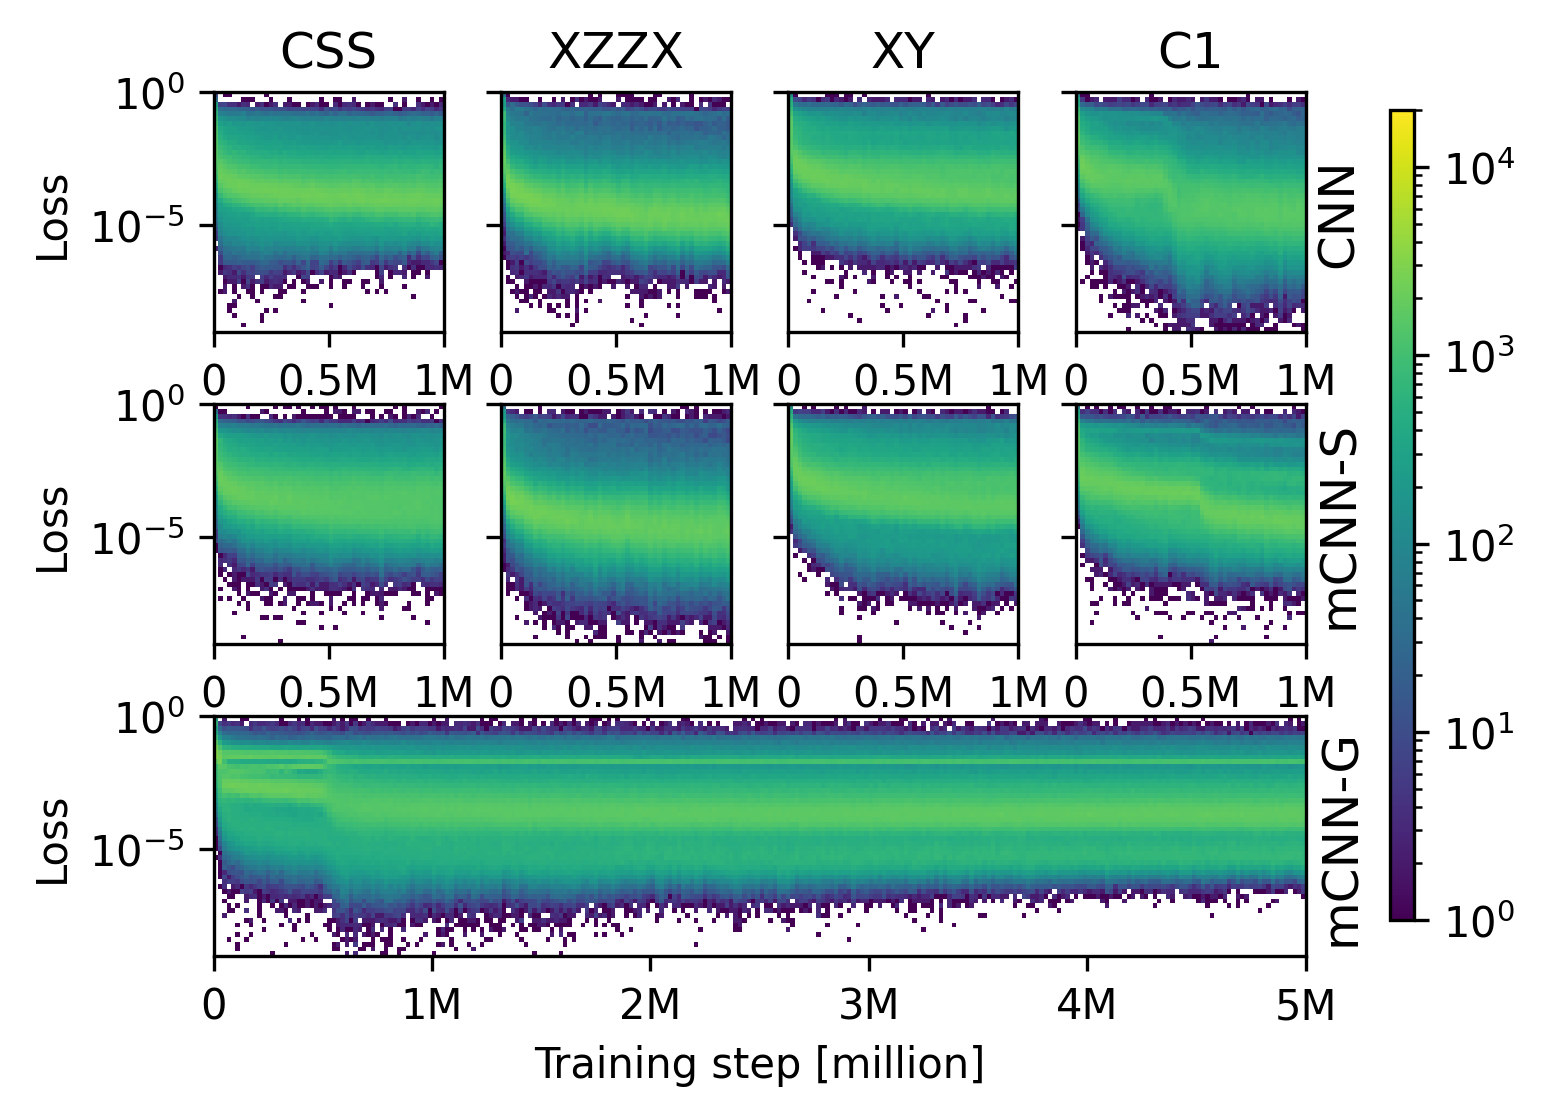

In [12]:
L = 7

deformations = {
    "CSS": jnp.zeros(L**2, dtype=jnp.int32),
    "XZZX": jnp.zeros(L**2, dtype=jnp.int32).at[::2].set(3),
    "XY": jnp.zeros(L**2, dtype=jnp.int32).at[:].set(2),
    "C1": jnp.zeros((L, L), dtype=jnp.int32).at[1::2, ::2].set(3).flatten().at[::2].set(2),
}

decoders = ["CNN", "CNN-S", "CNN-G"]

deformation_names = ['CSS', 'XZZX', 'XY', 'C1']

match L:
    case 3:
        bins_y = jnp.logspace(-9, 0, 51)
    case 5:
        bins_y = jnp.logspace(-11, 0, 51)
    case 7:
        bins_y = jnp.logspace(-9, 0, 51)

fig = plt.figure(figsize=(len(deformation_names), len(decoders)), dpi=300)

x_res = 50

# Create subplots using subplot2grid
for i, decoder_name in enumerate(decoders):
    for j, deformation_name in enumerate(deformation_names):
        if i == len(decoders) - 1:  # Last row
            ax = plt.subplot2grid(
                (len(decoders), len(deformation_names)), 
                (i, 0), 
                colspan=len(deformation_names), 
                fig=fig
            )
            ax.set_yscale('log')
            ax.set_ylabel(f'Loss')
            if j == 0:
                ax.annotate(
                    "m"+decoder_name if "CNN-" in decoder_name else decoder_name,
                    xy=(1.01, 0.5),
                    xycoords='axes fraction',
                    ha='left',
                    va='center',
                    fontsize=12,
                    rotation=90
                )
            # Plot the loss data
            loss = jnp.load(f"data/loss_CNN-G-{L}.npy")
            ax.hist2d(
                x=jnp.arange(loss.shape[0]), 
                y=loss, 
                bins=[
                    jnp.linspace(0, loss.shape[0], 5*x_res+1),
                    bins_y,
                ],
                norm=LogNorm(vmin=1, vmax=2E4),
            )
            # ax.plot(
            #     jnp.arange(5*x_res) * loss.shape[0] / (5*x_res) + loss.shape[0] / (5*x_res) / 2, 
            #     loss.reshape(-1, loss.shape[0] // (5*x_res)).mean(axis=1),
            #     '.k', 
            #     lw=0.5, 
            #     ms=2,
            #     mew=0,
            #     label='Mean loss'
            # )
            ax.set_xlabel('Training step [million]')
            ax.set_xticks([0, 1E6, 2E6, 3E6, 4E6, 5E6])
            ax.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M'])
            # ax.legend(
            #     loc='upper center', 
            #     bbox_to_anchor=(0.5, 4.3),
            #     markerscale=2,
            # )
            break  # Skip the rest of the columns for this row
        else:
            ax = plt.subplot2grid(
                (len(decoders), len(deformation_names)), 
                (i, j), 
                fig=fig
            )
            ax.set_yscale('log')
            if j == len(deformation_names) - 1:  # Last column
                ax.annotate(
                    "m"+decoder_name if "CNN-" in decoder_name else decoder_name,
                    xy=(1.04, 0.5),
                    xycoords='axes fraction',
                    ha='left',
                    va='center',
                    fontsize=12,
                    rotation=90
                )
            if j == 0:
                ax.set_ylabel('Loss')
            else:
                ax.set_yticklabels([])
            if i == 0:
                ax.set_title(f'{deformation_name}')
            # Plot the loss data
            loss = jnp.load(f"data/loss_{decoder_name}-{L}-{''.join([str(d) for d in deformations[deformation_name]])}.npy")
            ax.hist2d(
                x=jnp.arange(loss.shape[0]), 
                y=loss, 
                bins=[
                    jnp.linspace(0, loss.shape[0], x_res+1),
                    bins_y,
                ],
                norm=LogNorm(vmin=1, vmax=2E4),
            )
            # ax.plot(
            #     jnp.arange(x_res) * loss.shape[0] / x_res + loss.shape[0] / x_res / 2, 
            #     loss.reshape(-1, loss.shape[0] // x_res).mean(axis=1),
            #     '.k', 
            #     lw=0.5, 
            #     ms=2,
            #     mew=0,
            #     label='Mean loss'
            # )
            # ax.set_xlabel('Training step [million]')
            ax.set_xticks([0, .5E6, 1E6])
            ax.set_xticklabels(['0', '0.5M', '1M'])

plt.subplots_adjust(left=0.02, right=0.93, top=0.98, bottom=0.02, wspace=0.25, hspace=0.3)

cbar = fig.colorbar(ax.collections[0], cax=fig.add_axes((1,0.06,.02,.9)))

figname = f"decoder_loss-{L}"
print(figname)
plt.savefig(f"figs/{figname}.eps", dpi=300, bbox_inches='tight')
plt.savefig(f"figs/{figname}.pdf", dpi=300, bbox_inches='tight')
plt.savefig(f"figs/{figname}.png", dpi=300, bbox_inches='tight')

plt.show()